In [17]:
import torch
from torch import nn ## for neural net
import matplotlib as plt ## for plotting

torch.__version__

# Setup device agnostic code
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Using device: {device}")

# create known params
weight = 0.7
bias = 0.3

# create data 

start = 0 
end = 1

step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias


train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:] 

len(X_train), len(y_train), len(X_test), len(y_test)

## X - data
## y is - labels




Using device: mps


(40, 40, 10, 10)

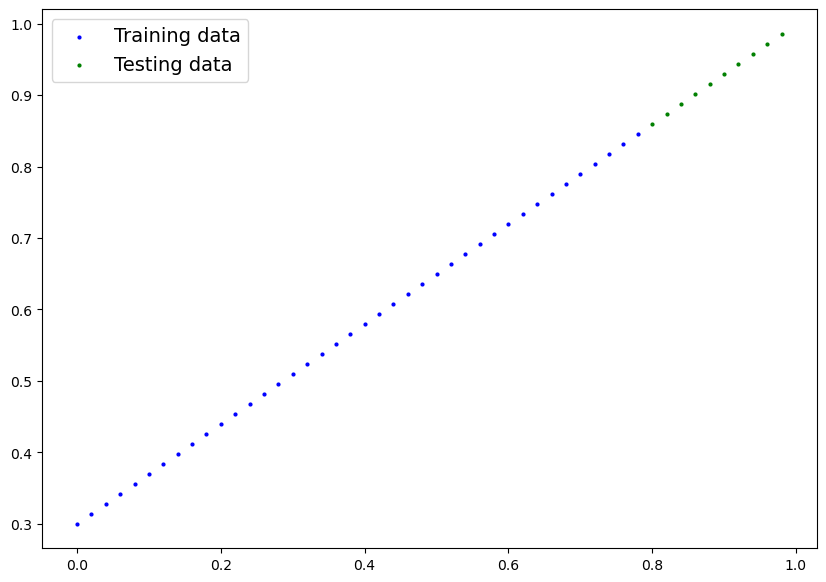

In [18]:
import matplotlib.pyplot as plt

def plotting_predictions(train_data = X_train, 
                         train_labels = y_train,
                         test_data = X_test,
                         test_labels = y_test,
                         predictions = None):
    
    plt.figure(figsize = (10,7))

      # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

plotting_predictions()



In [25]:
class LinearRegressionModelV2(nn.Module):


    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


torch.manual_seed(42)

model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()


(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [26]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [27]:
# Set model to GPU if it's available, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='mps', index=0)

In [28]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr = 0.01)

In [29]:
torch.manual_seed(42)

epochs = 1000

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):

    model_1.train()

    y_pred = model_1(X_train)

    loss = loss_fn(y_pred, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_pred = model_1(X_test)

        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")







Epoch: 0 | Train loss: 0.5551779270172119 | Test loss: 0.5739762783050537
Epoch: 100 | Train loss: 0.006215682718902826 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 300 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 400 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 500 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 600 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 700 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 800 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904
Epoch: 900 | Train loss: 0.0012645088136196136 | Test loss: 0.013801807537674904


In [30]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3025], device='mps:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


In [32]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='mps:0')

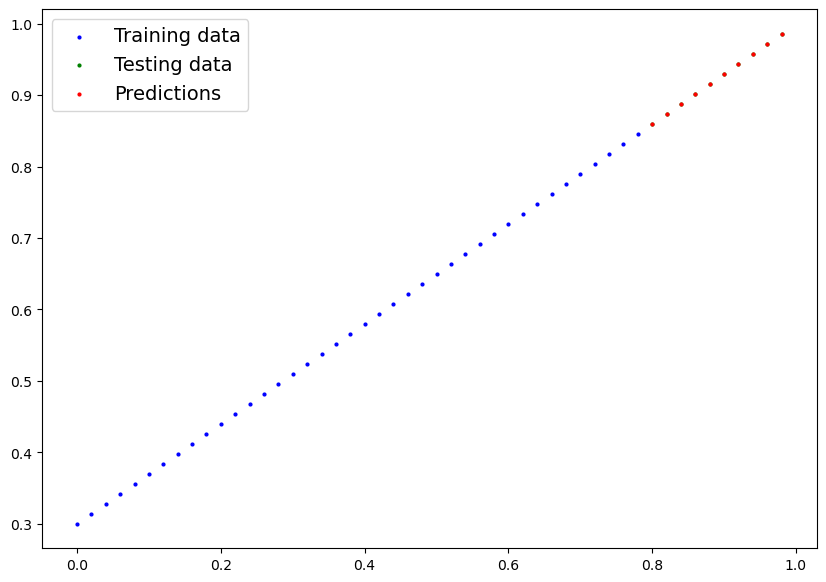

In [36]:
plotting_predictions(predictions=y_preds.cpu())

In [37]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("outputs")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: outputs/01_pytorch_workflow_model_1.pth


In [38]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
mps:0


In [39]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='mps:0')